# NVIDIA Chip Estimates (v2 - Functional Sampling)

This notebook uses a functional sampling architecture where `nvidia_sample()` returns a single sample of chip counts for all quarters and chips, with correlated parameters:
- **Hardware share**: Sampled once per `nvidia_sample()` call (correlated across quarters)
- **Base prices**: Sampled once per chip, with deflation applied deterministically

This gives wider, more realistic confidence intervals for cumulative totals compared to independent sampling.

In [1]:
import squigglepy as sq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from squigglepy.numbers import K, M, B

sq.set_seed(42)
np.random.seed(42)
N_SAMPLES = 5000
H100_TOPS = 1979

In [2]:
# NVIDIA chip specs: 8-bit TFLOP/s
CHIP_SPECS = {
    'A100':      {'tops': 624},
    'A800':      {'tops': 624},
    'H100/H200': {'tops': 1979},
    'H800':      {'tops': 1979},
    'H20':       {'tops': 296},
    'B200':      {'tops': 5000},
    'B300':      {'tops': 5000},
}
CHIP_TYPES = list(CHIP_SPECS.keys())

# Colors for visualization
CHIP_COLORS = {
    'A100': 'lightcoral',
    'A800': 'sienna',
    'H100/H200': 'steelblue',
    'H800': 'firebrick',
    'H20': 'orange',
    'B200': 'mediumseagreen',
    'B300': 'seagreen',
}

# Hardware share of compute revenue (vs cloud/software)
HARDWARE_SHARE = sq.to(0.96, 0.99, credibility=80)

In [3]:
# Load revenue and price data from Google Sheets
revenue_df = pd.read_csv(
    "https://docs.google.com/spreadsheets/d/1Yhu87Rw--9tviAuBwg_luL3OFAFkdHdVfli6tN215Xk/export?format=csv&gid=0"
).set_index('Quarter')

prices_df = pd.read_csv(
    "https://docs.google.com/spreadsheets/d/1Yhu87Rw--9tviAuBwg_luL3OFAFkdHdVfli6tN215Xk/export?format=csv&gid=1819303346"
).set_index('Year')

QUARTERS = revenue_df.index.tolist()

revenue_df[['Compute revenue'] + [f'{chip} share' for chip in CHIP_TYPES]].head()

,Compute revenue,A100 share,A800 share,H100/H200 share,H800 share,H20 share,B200 share,B300 share
Quarter,,,,,,,,
FY23Q1,2.81,1.00,0.00,0.0,0.0,0.0,0.0,0.0
FY23Q2,2.86,1.00,0.00,0.0,0.0,0.0,0.0,0.0
FY23Q3,2.87,0.90,0.00,0.1,0.0,0.0,0.0,0.0
FY23Q4,2.72,0.31,0.19,0.5,0.0,0.0,0.0,0.0
FY24Q1,3.35,0.21,0.09,0.6,0.1,0.0,0.0,0.0


In [4]:
# ======================================================================
# Base price and deflation setup
# ======================================================================

# Map chip types to their column names in the prices CSV
PRICE_COLUMN_MAP = {'H100/H200': 'H100'}

# Fallback prices if not found in CSV
FALLBACK_PRICES = {
    'A100': (10*K, 15*K), 'A800': (10*K, 15*K), 'H100/H200': (20*K, 30*K),
    'H800': (20*K, 30*K), 'H20': (10*K, 15*K), 'B200': (33*K, 42*K), 'B300': (33*K, 42*K)
}


def get_price_dist_for_year(chip, year):
    """Get price distribution for a chip in a given year."""
    csv_chip_name = PRICE_COLUMN_MAP.get(chip, chip)
    low_col, high_col = f'{csv_chip_name} low', f'{csv_chip_name} high'

    if low_col in prices_df.columns and high_col in prices_df.columns:
        if year in prices_df.index:
            low = prices_df.loc[year, low_col]
            high = prices_df.loc[year, high_col]
            if pd.notna(low) and pd.notna(high):
                return sq.to(low, high, credibility=80)
    return sq.to(*FALLBACK_PRICES.get(chip, (20*K, 30*K)), credibility=80)


def find_first_year_with_price(chip):
    """Find the first year with price data for a chip."""
    csv_chip_name = PRICE_COLUMN_MAP.get(chip, chip)
    low_col = f'{csv_chip_name} low'
    if low_col in prices_df.columns:
        for year in sorted(prices_df.index):
            if pd.notna(prices_df.loc[year, low_col]):
                return year
    return min(prices_df.index)


def get_price_year_for_quarter(quarter):
    """Get the calendar year to use for pricing a quarter."""
    start_date = revenue_df.loc[quarter, 'Start Date']
    return pd.to_datetime(start_date).year


def get_price_bounds(chip, year):
    """Get (low, high) price bounds for a chip in a given year, or None if unavailable."""
    csv_chip_name = PRICE_COLUMN_MAP.get(chip, chip)
    low_col, high_col = f'{csv_chip_name} low', f'{csv_chip_name} high'
    if low_col in prices_df.columns and high_col in prices_df.columns:
        if year in prices_df.index:
            low = prices_df.loc[year, low_col]
            high = prices_df.loc[year, high_col]
            if pd.notna(low) and pd.notna(high):
                return (low, high)
    return None


def get_deflation_factor(quarter, chip):
    """Get deflation factor for a chip in a quarter (ratio of current to base price)."""
    price_year = get_price_year_for_quarter(quarter)
    base_year = BASE_YEAR[chip]
    if price_year <= base_year:
        return 1.0

    base_bounds = get_price_bounds(chip, base_year)
    current_bounds = get_price_bounds(chip, price_year)

    if base_bounds and current_bounds:
        # Ratio of geometric means
        base_geomean = np.sqrt(base_bounds[0] * base_bounds[1])
        current_geomean = np.sqrt(current_bounds[0] * current_bounds[1])
        return current_geomean / base_geomean
    return 1.0


# Build base prices dict (first year available for each chip)
BASE_YEAR = {chip: find_first_year_with_price(chip) for chip in CHIP_TYPES}
BASE_PRICES = {chip: get_price_dist_for_year(chip, BASE_YEAR[chip]) for chip in CHIP_TYPES}

print("Base years and price distributions:")
for chip in CHIP_TYPES:
    bounds = get_price_bounds(chip, BASE_YEAR[chip])
    if bounds:
        print(f"  {chip}: {BASE_YEAR[chip]} -> ${bounds[0]:,.0f} - ${bounds[1]:,.0f}")
    else:
        fb = FALLBACK_PRICES.get(chip, (20*K, 30*K))
        print(f"  {chip}: {BASE_YEAR[chip]} -> ${fb[0]:,.0f} - ${fb[1]:,.0f} (fallback)")

Base years and price distributions:
  A100: 2022 -> $10,000 - $15,000
  A800: 2022 -> $10,000 - $15,000
  H100/H200: 2022 -> $27,000 - $35,000
  H800: 2023 -> $25,000 - $35,000
  H20: 2024 -> $10,000 - $15,000
  B200: 2024 -> $33,000 - $42,000
  B300: 2025 -> $38,000 - $49,000


In [5]:
# ======================================================================
# Core sampling function
# ======================================================================

def nvidia_sample():
    """
    Sample chip counts for all quarters and chips in a single call.

    Correlates parameters within each sample:
    - hardware_share: sampled once, applies to all quarters
    - base_prices: sampled once per chip, deflation applied deterministically

    Returns:
        dict: {quarter: {chip: chip_count}} for a single sample
    """
    # Sample correlated parameters ONCE for this sample
    hardware_share = HARDWARE_SHARE @ 1
    base_prices = {chip: BASE_PRICES[chip] @ 1 for chip in CHIP_TYPES}

    result = {}
    for quarter in QUARTERS:
        result[quarter] = {}
        base_revenue = revenue_df.loc[quarter, 'Compute revenue'] * B * hardware_share

        for chip in CHIP_TYPES:
            share = revenue_df.loc[quarter, f'{chip} share']
            if pd.notna(share) and share > 0:
                # Apply deflation factor to base price
                price = base_prices[chip] * get_deflation_factor(quarter, chip)
                result[quarter][chip] = (base_revenue * share) / price
            else:
                result[quarter][chip] = 0.0
    return result

In [6]:
# ======================================================================
# Helper functions for aggregation
# ======================================================================

def cumulative_by_chip(sample):
    """Sum a single sample across all quarters, by chip."""
    totals = {chip: 0.0 for chip in CHIP_TYPES}
    for quarter in sample:
        for chip in CHIP_TYPES:
            totals[chip] += sample[quarter][chip]
    return totals


def total_chips(sample):
    """Sum a single sample across all quarters and all chips."""
    return sum(cumulative_by_chip(sample).values())


def quarterly_total(sample):
    """Sum a single sample across all chips, by quarter."""
    return {q: sum(sample[q].values()) for q in sample}


def cumulative_total_by_quarter(sample):
    """Running total by quarter (cumulative sum of all chips over time)."""
    running = 0
    result = {}
    for q in QUARTERS:
        running += sum(sample[q].values())
        result[q] = running
    return result

In [7]:
# ======================================================================
# Helper functions for intervals
# ======================================================================

def get_quarterly_intervals(samples, percentiles=[5, 50, 95]):
    """
    Extract per-quarter, per-chip intervals from list of samples.

    Args:
        samples: list of {quarter: {chip: count}} dicts

    Returns:
        dict: {quarter: {chip: {'p5': x, 'p50': y, 'p95': z}}}
    """
    # Reorganize: {quarter: {chip: [values]}}
    by_qc = {q: {c: [] for c in CHIP_TYPES} for q in QUARTERS}
    for s in samples:
        for q in QUARTERS:
            for c in CHIP_TYPES:
                by_qc[q][c].append(s[q][c])

    # Compute percentiles
    result = {}
    for q in QUARTERS:
        result[q] = {}
        for c in CHIP_TYPES:
            arr = np.array(by_qc[q][c])
            result[q][c] = {f'p{p}': np.percentile(arr, p) for p in percentiles}
    return result


def get_chip_intervals(samples, percentiles=[5, 50, 95]):
    """
    Extract per-chip intervals from list of cumulative samples.

    Args:
        samples: list of {chip: count} dicts

    Returns:
        dict: {chip: {'p5': x, 'p50': y, 'p95': z}}
    """
    by_chip = {c: [] for c in CHIP_TYPES}
    for s in samples:
        for c in CHIP_TYPES:
            by_chip[c].append(s[c])

    result = {}
    for c in CHIP_TYPES:
        arr = np.array(by_chip[c])
        result[c] = {f'p{p}': np.percentile(arr, p) for p in percentiles}
    return result


def get_scalar_intervals(samples, percentiles=[5, 50, 95]):
    """
    Extract intervals from list of scalar samples.

    Args:
        samples: list of scalar values

    Returns:
        dict: {'p5': x, 'p50': y, 'p95': z}
    """
    arr = np.array(samples)
    return {f'p{p}': np.percentile(arr, p) for p in percentiles}

In [8]:
# ======================================================================
# Main execution: collect samples
# ======================================================================

# === Per-quarter samples ===
quarterly_samples = sq.sample(nvidia_sample, n=N_SAMPLES)
quarterly_intervals = get_quarterly_intervals(quarterly_samples)

# === Cumulative samples (per chip) ===
cumulative_samples = sq.sample(lambda: cumulative_by_chip(nvidia_sample()), n=N_SAMPLES)
cumulative_intervals = get_chip_intervals(cumulative_samples)

# === Total Nvidia stock (all chips, all quarters) ===
total_samples = sq.sample(lambda: total_chips(nvidia_sample()), n=N_SAMPLES)
total_intervals = get_scalar_intervals(total_samples)

# === Cumulative total over time (running total by quarter) ===
cumulative_total_samples = sq.sample(lambda: cumulative_total_by_quarter(nvidia_sample()), n=N_SAMPLES)

print(f"Collected {N_SAMPLES} samples for quarterly, cumulative, and total estimates.")

Collected 5000 samples for quarterly, cumulative, and total estimates.


In [9]:
# ======================================================================
# Display quarterly summary by chip type
# ======================================================================

print("=== QUARTERLY CHIP SALES BY TYPE ===\n")

for chip in CHIP_TYPES:
    # Check if this chip has any sales
    has_sales = any(quarterly_intervals[q][chip]['p50'] > 0 for q in QUARTERS)
    if not has_sales:
        continue
    
    print(f"--- {chip} ---")
    print(f"{'Quarter':<10} {'Units (p50)':>12} {'Units (90% CI)':>24} {'H100e (p50)':>12} {'H100e (90% CI)':>24}")
    
    for quarter in QUARTERS:
        stats = quarterly_intervals[quarter][chip]
        if stats['p50'] > 0:
            h100e_factor = CHIP_SPECS[chip]['tops'] / H100_TOPS
            u_p5, u_p50, u_p95 = int(stats['p5']), int(stats['p50']), int(stats['p95'])
            h_p5, h_p50, h_p95 = int(stats['p5'] * h100e_factor), int(stats['p50'] * h100e_factor), int(stats['p95'] * h100e_factor)
            print(f"{quarter:<10} {u_p50:>12,} {f'({u_p5:,} - {u_p95:,})':>24} {h_p50:>12,} {f'({h_p5:,} - {h_p95:,})':>24}")
    print()

=== QUARTERLY CHIP SALES BY TYPE ===

--- A100 ---
Quarter     Units (p50)           Units (90% CI)  H100e (p50)           H100e (90% CI)
FY23Q1          222,935      (171,337 - 288,816)       70,294        (54,024 - 91,066)
FY23Q2          226,902      (174,385 - 293,955)       71,544        (54,985 - 92,687)
FY23Q3          204,926      (157,496 - 265,485)       64,615        (49,660 - 83,710)
FY23Q4           66,896        (51,413 - 86,665)       21,093        (16,211 - 27,326)
FY24Q1           55,813        (42,895 - 72,306)       17,598        (13,525 - 22,799)
FY24Q2           68,308        (52,498 - 88,495)       21,538        (16,553 - 27,903)
FY24Q3           47,205        (36,279 - 61,155)       14,884        (11,439 - 19,282)

--- A800 ---
Quarter     Units (p50)           Units (90% CI)  H100e (p50)           H100e (90% CI)
FY23Q4           41,106        (31,448 - 53,638)       12,961         (9,916 - 16,912)
FY24Q1           23,981        (18,347 - 31,292)        7,561    

In [10]:
# ======================================================================
# Display cumulative summary
# ======================================================================

print("\nCumulative NVIDIA Chip Sales (FY23-FY27)")
print(f"{'Version':<12} {'p5':>12} {'p50':>12} {'p95':>12}")
print("-" * 51)

for chip in CHIP_TYPES:
    stats = cumulative_intervals[chip]
    if stats['p50'] > 0:
        print(f"{chip:<12} {int(stats['p5']):>12,} {int(stats['p50']):>12,} {int(stats['p95']):>12,}")

print("-" * 51)
print(f"{'TOTAL':<12} {int(total_intervals['p5']):>12,} {int(total_intervals['p50']):>12,} {int(total_intervals['p95']):>12,}")

# H100 equivalents
print("\n\nH100 Equivalents (8-bit TOPS basis)")
print(f"{'Version':<12} {'p5':>12} {'p50':>12} {'p95':>12}")
print("-" * 51)

h100e_total = {'p5': 0, 'p50': 0, 'p95': 0}
for chip in CHIP_TYPES:
    stats = cumulative_intervals[chip]
    if stats['p50'] > 0:
        h100e_factor = CHIP_SPECS[chip]['tops'] / H100_TOPS
        h_p5, h_p50, h_p95 = int(stats['p5'] * h100e_factor), int(stats['p50'] * h100e_factor), int(stats['p95'] * h100e_factor)
        print(f"{chip:<12} {h_p5:>12,} {h_p50:>12,} {h_p95:>12,}")
        h100e_total['p5'] += h_p5
        h100e_total['p50'] += h_p50
        h100e_total['p95'] += h_p95

print("-" * 51)
print(f"{'TOTAL':<12} {h100e_total['p5']:>12,} {h100e_total['p50']:>12,} {h100e_total['p95']:>12,}")


Cumulative NVIDIA Chip Sales (FY23-FY27)
Version                p5          p50          p95
---------------------------------------------------
A100              697,268      897,659    1,167,065
A800               93,133      121,729      156,793
H100/H200       3,648,639    4,311,667    5,114,834
H800               93,509      116,656      144,287
H20             1,157,567    1,495,379    1,949,243
B200            1,369,741    1,602,645    1,863,763
B300              794,794      939,049    1,103,752
---------------------------------------------------
TOTAL           8,651,062    9,536,228   10,520,928


H100 Equivalents (8-bit TOPS basis)
Version                p5          p50          p95
---------------------------------------------------
A100              219,856      283,041      367,988
A800               29,366       38,382       49,438
H100/H200       3,648,639    4,311,667    5,114,834
H800               93,509      116,656      144,287
H20               173,137      223,6

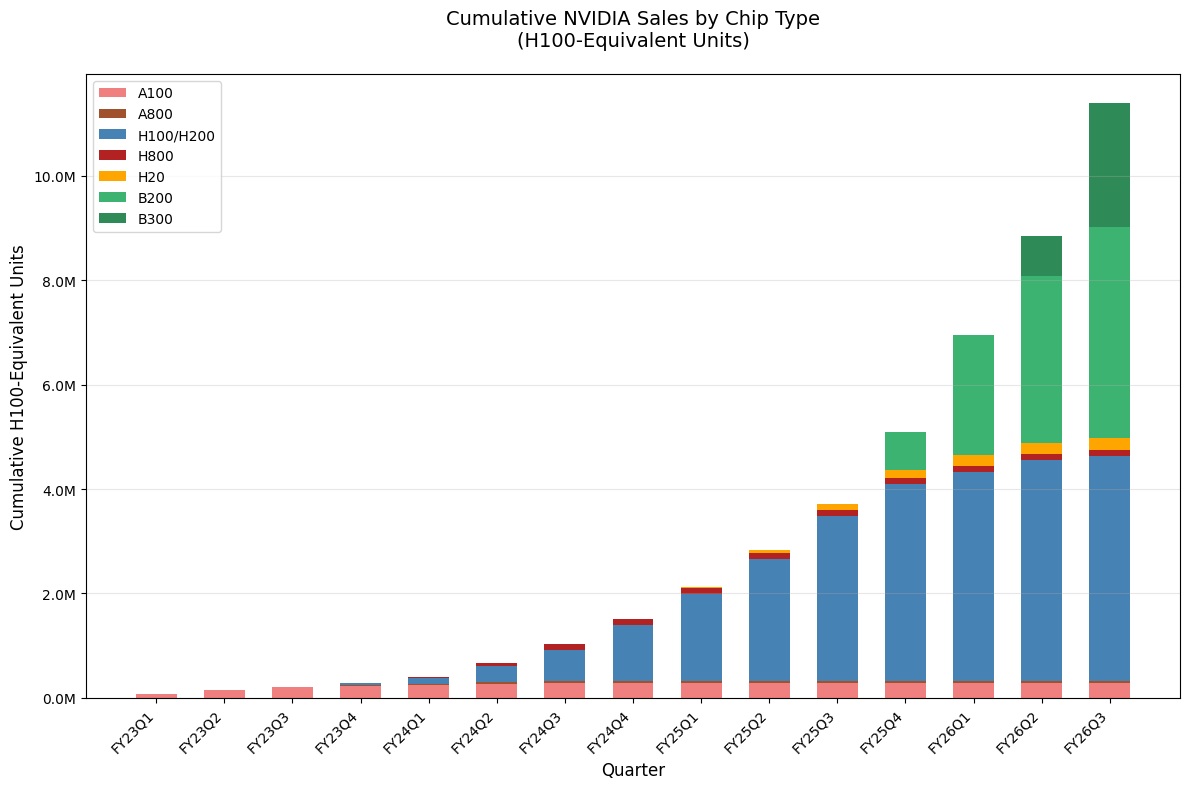

In [11]:
# ======================================================================
# Cumulative NVIDIA Sales by Chip Type (H100-equivalent units)
# ======================================================================

# Get median values for each chip type, converted to H100-equivalents
chip_medians = {}
for chip in CHIP_TYPES:
    quarterly_medians = [quarterly_intervals[q][chip]['p50'] for q in QUARTERS]
    h100e_ratio = CHIP_SPECS[chip]['tops'] / H100_TOPS
    chip_medians[chip] = np.array(quarterly_medians) * h100e_ratio

# Calculate cumulative sums
chip_cumulative = {chip: np.cumsum(chip_medians[chip]) for chip in CHIP_TYPES}

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(QUARTERS))
width = 0.6

bottom = np.zeros(len(QUARTERS))
for chip in CHIP_TYPES:
    ax.bar(x, chip_cumulative[chip], width, label=chip, bottom=bottom, color=CHIP_COLORS[chip])
    bottom += chip_cumulative[chip]

ax.set_ylabel('Cumulative H100-Equivalent Units', fontsize=12)
ax.set_xlabel('Quarter', fontsize=12)
ax.set_title('Cumulative NVIDIA Sales by Chip Type\n(H100-Equivalent Units)', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(QUARTERS, rotation=45, ha='right')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'{y/1e6:.1f}M'))
ax.grid(True, alpha=0.3, axis='y')
ax.legend(fontsize=10, loc='upper left')

plt.tight_layout()
plt.show()

In [12]:
# ======================================================================
# Convert to legacy format for export functions
# ======================================================================

# The export functions expect {quarter: {chip: [list of samples]}}
# We need to reorganize our quarterly_samples to match

sim_results = {q: {c: [] for c in CHIP_TYPES} for q in QUARTERS}
for sample in quarterly_samples:
    for q in QUARTERS:
        for c in CHIP_TYPES:
            sim_results[q][c].append(sample[q][c])

# Convert lists to arrays for compatibility
for q in QUARTERS:
    for c in CHIP_TYPES:
        sim_results[q][c] = np.array(sim_results[q][c])

print("Converted samples to legacy format for export.")

Converted samples to legacy format for export.


In [13]:
# ==============================================
# EXPORT NON-INTERPOLATED FISCAL QUARTER RESULTS
# ==============================================

from datetime import datetime

# Get current timestamp for notes
timestamp = datetime.now().strftime("%m-%d-%Y %H:%M")
generated_note = f"Estimates generated on: {timestamp}"

# Create rows for output (fiscal quarters, non-interpolated)
rows = []

for quarter in QUARTERS:
    start_date = revenue_df.loc[quarter, 'Start Date']
    end_date = revenue_df.loc[quarter, 'End Date']
    
    for chip_type in CHIP_SPECS:
        arr = np.array(sim_results[quarter][chip_type])
        if arr.sum() > 0:
            # Calculate percentiles for units
            u_p5, u_p50, u_p95 = [int(np.percentile(arr, p)) for p in [5, 50, 95]]
            
            # Calculate H100 equivalents
            h100e_factor = CHIP_SPECS[chip_type]['tops'] / H100_TOPS
            h_p5, h_p50, h_p95 = [int(p * h100e_factor) for p in [u_p5, u_p50, u_p95]]
            
            # Use display name (H100/H200 -> H100 for display)
            display_name = 'H100' if chip_type == 'H100/H200' else chip_type
            
            rows.append({
                'Name': f"{quarter} - {display_name}",
                'Chip manufacturer': 'Nvidia',
                'Start date': start_date,
                'End date': end_date,
                'Compute estimate in H100e (median)': h_p50,
                'H100e (5th percentile)': h_p5,
                'H100e (95th percentile)': h_p95,
                'Number of Units': u_p50,
                'Number of Units (5th percentile)': u_p5,
                'Number of Units (95th percentile)': u_p95,
                'Source / Link': '',
                'Notes': generated_note,
                'Chip type': display_name,
                'Last Modified By': '',
                'Last Modified': '',
            })

# Create output dataframe
nvidia_chip_timelines = pd.DataFrame(rows)

# Save to CSV
output_path = 'nvidia_chip_timelines.csv'
nvidia_chip_timelines.to_csv(output_path, index=False)

print(f"Exported to {output_path}")
print(nvidia_chip_timelines[['Name', 'Chip manufacturer', 'Start date', 'End date', 
                              'Compute estimate in H100e (median)', 'H100e (5th percentile)', 
                              'H100e (95th percentile)', 'Number of Units', 'Chip type']].to_string())

Exported to nvidia_chip_timelines.csv
             Name Chip manufacturer  Start date    End date  Compute estimate in H100e (median)  H100e (5th percentile)  H100e (95th percentile)  Number of Units Chip type
0   FY23Q1 - A100            Nvidia  2022-01-31  2022-05-01                               70293                   54024                    91066           222935      A100
1   FY23Q2 - A100            Nvidia  2022-05-02  2022-07-31                               71544                   54985                    92687           226902      A100
2   FY23Q3 - A100            Nvidia  2022-08-01  2022-10-30                               64615                   49660                    83710           204926      A100
3   FY23Q3 - H100            Nvidia  2022-08-01  2022-10-30                                9115                    7685                    10776             9115      H100
4   FY23Q4 - A100            Nvidia  2022-10-31  2023-01-29                               21093       

In [14]:
# ==============================================
# INTERPOLATE TO CALENDAR QUARTERS
# ==============================================

from chip_estimates_utils import (
    interpolate_to_calendar_quarters,
    summarize_calendar_quarters,
)

# Use Start Date and End Date directly from revenue_df
quarter_dates = {q: (revenue_df.loc[q, 'Start Date'], revenue_df.loc[q, 'End Date']) for q in QUARTERS}

print("NVIDIA fiscal quarter to calendar date mapping:")
for q, (start, end) in list(quarter_dates.items())[:5]:
    print(f"  {q}: {start} to {end}")
print("  ...")

# Interpolate to calendar quarters
calendar_results = interpolate_to_calendar_quarters(sim_results, quarter_dates, verbose=False)

# Display summary
calendar_summary = summarize_calendar_quarters(calendar_results)
print("\nNVIDIA Chip Volumes by Calendar Quarter (median with 90% CI)")
print(calendar_summary.to_string(index=False))

NVIDIA fiscal quarter to calendar date mapping:
  FY23Q1: 2022-01-31 to 2022-05-01
  FY23Q2: 2022-05-02 to 2022-07-31
  FY23Q3: 2022-08-01 to 2022-10-30
  FY23Q4: 2022-10-31 to 2023-01-29
  FY24Q1: 2023-01-30 to 2023-04-30
  ...

NVIDIA Chip Volumes by Calendar Quarter (median with 90% CI)
Quarter             A100          A800        H100/H200          H800              H20             B200             B300               Total
Q1 2022 147k (113k-190k)             -                -             -                -                -                -    147k (113k-190k)
Q2 2022 226k (173k-292k)             -                -             -                -                -                -    226k (173k-292k)
Q3 2022 215k (165k-278k)             -       6k (5k-7k)             -                -                -                -    221k (170k-285k)
Q4 2022  113k (87k-147k) 28k (21k-37k)    32k (27k-38k)             -                -                -                -    174k (136k-221k)
Q1 2

In [15]:
# ==============================================
# EXPORT INTERPOLATED CALENDAR QUARTER RESULTS
# ==============================================

from datetime import datetime

# Get current timestamp for notes
timestamp = datetime.now().strftime("%m-%d-%Y %H:%M")
generated_note = f"Estimates generated on: {timestamp}"

# Get first and last dates from Nvidia fiscal quarter data
nvidia_first_start = revenue_df['Start Date'].iloc[0]
nvidia_last_end = revenue_df['End Date'].iloc[-1]

# Parse date strings to datetime for comparison
def parse_date(date_str):
    """Parse date string to datetime."""
    return pd.to_datetime(date_str)

nvidia_first_start_dt = parse_date(nvidia_first_start)
nvidia_last_end_dt = parse_date(nvidia_last_end)

# Calendar quarter to date range mapping
def get_calendar_quarter_dates(cal_q):
    """Return (start_date, end_date) strings for a calendar quarter like 'Q1 2024'."""
    parts = cal_q.split()
    q_num = int(parts[0][1])
    year = int(parts[1])
    if q_num == 1:
        return f"1/1/{year}", f"3/31/{year}"
    elif q_num == 2:
        return f"4/1/{year}", f"6/30/{year}"
    elif q_num == 3:
        return f"7/1/{year}", f"9/30/{year}"
    else:
        return f"10/1/{year}", f"12/31/{year}"

def format_date_for_note(dt):
    """Format datetime as M/D/YYYY for notes (cross-platform)."""
    if hasattr(dt, 'month'):
        return f"{dt.month}/{dt.day}/{dt.year}"
    return str(dt)

def get_incomplete_note(cal_q_start, cal_q_end):
    """Return note if calendar quarter extends beyond Nvidia fiscal data coverage."""
    cal_start_dt = pd.to_datetime(cal_q_start, format='%m/%d/%Y')
    cal_end_dt = pd.to_datetime(cal_q_end, format='%m/%d/%Y')

    starts_before = cal_start_dt < nvidia_first_start_dt
    ends_after = cal_end_dt > nvidia_last_end_dt

    first_start_str = format_date_for_note(nvidia_first_start_dt)
    last_end_str = format_date_for_note(nvidia_last_end_dt)

    if starts_before and ends_after:
        return f"Estimate is incomplete because it is based on Nvidia fiscal quarters beginning {first_start_str} and ending {last_end_str}"
    elif starts_before:
        return f"Estimate is incomplete because it is based on Nvidia fiscal quarters beginning {first_start_str}"
    elif ends_after:
        return f"Estimate is incomplete because it is based on Nvidia fiscal quarters ending {last_end_str}"
    return None

# Create rows for output
rows = []

for quarter in calendar_results:
    start_date, end_date = get_calendar_quarter_dates(quarter)
    incomplete_note = get_incomplete_note(start_date, end_date)

    for chip_type in CHIP_SPECS:
        stats = calendar_results[quarter][chip_type]
        if stats['p50'] > 0:
            # Calculate H100 equivalents
            h100e_factor = CHIP_SPECS[chip_type]['tops'] / H100_TOPS

            # Build notes field
            notes = generated_note
            if incomplete_note:
                notes = f"{incomplete_note}. {notes}"

            rows.append({
                'Name': f"{quarter} - {chip_type}",
                'Chip manufacturer': 'Nvidia',
                'Start date': start_date,
                'End date': end_date,
                'Compute estimate in H100e (median)': int(stats['p50'] * h100e_factor),
                'H100e (5th percentile)': int(stats['p5'] * h100e_factor),
                'H100e (95th percentile)': int(stats['p95'] * h100e_factor),
                'Number of Units': int(stats['p50']),
                'Number of Units (5th percentile)': int(stats['p5']),
                'Number of Units (95th percentile)': int(stats['p95']),
                'Source / Link': '',
                'Notes': notes,
                'Chip type': chip_type,
                'Last Modified By': '',
                'Last Modified': '',
            })

# Create output dataframe
nvidia_timelines_interpolated = pd.DataFrame(rows)

# Save to CSV
output_path = 'nvidia_timelines_interpolated.csv'
nvidia_timelines_interpolated.to_csv(output_path, index=False)

print(f"Exported to {output_path}")
print(f"Nvidia fiscal data coverage: {format_date_for_note(nvidia_first_start_dt)} to {format_date_for_note(nvidia_last_end_dt)}")
print(nvidia_timelines_interpolated[['Name', 'Chip manufacturer', 'Start date', 'End date', 
                                      'Compute estimate in H100e (median)', 'H100e (5th percentile)', 
                                      'H100e (95th percentile)', 'Number of Units', 'Chip type']].head(20).to_string())

Exported to nvidia_timelines_interpolated.csv
Nvidia fiscal data coverage: 1/31/2022 to 10/26/2025
                   Name Chip manufacturer Start date    End date  Compute estimate in H100e (median)  H100e (5th percentile)  H100e (95th percentile)  Number of Units  Chip type
0        Q1 2022 - A100            Nvidia   1/1/2022   3/31/2022                               46347                   35620                    60044           146990       A100
1        Q2 2022 - A100            Nvidia   4/1/2022   6/30/2022                               71118                   54658                    92135           225551       A100
2        Q3 2022 - A100            Nvidia   7/1/2022   9/30/2022                               67686                   52020                    87688           214664       A100
3   Q3 2022 - H100/H200            Nvidia   7/1/2022   9/30/2022                                6110                    5151                     7223             6110  H100/H200
4        Q4